In [1]:
from __future__ import division

import csv
import json
import sys
import os
import numpy as np
import pandas as pd
import datetime

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

# Experiment parameters
EXP_DATE = '04052017'
MA_TYPE = 'SMA'
COMPONENT = 'Chloride'
# METHOD = 'RS2'
QC_RULES = ['13s','22s']

URefL = 106
LRefL = 99
UTL = 104
LTL =99
WINDOW = 50 


In [2]:
def df_to_series(df, method, qc=False, flags=False):
    
    """
    Return a value series for a given method
    """
    
    
    if qc == False:
        # get the requested test and method and create a new DF
        df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'val'
    elif qc == True:
        df_ = df.loc[(df.Test == 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'qc'


    else:
        print "Set qc flag: true if you want qc, false if you want result values"
        
    if flags == False:
        # take just the data and the value columns
        df_ = df_[['Verified','Value']]
    else:
        df_ = df_[['Verified','Decision']]


    try:
        if len(df_) != 0:
            # save to csv
            df_.to_csv('tmp.csv'.format(test, method), index=False)

            # read csv back in as a series
            series = pd.Series.from_csv('tmp.csv'.format(test, method),header=0)
        else:
            print(test)
            sys.exit("in df_to_series(): df_ was null")
            
    except Exception, e:
        print e 
        
    return series


def simple_moving_average(Window, ValTimeSeries):
    """
    Create a simple moving averages TimeSeries
    In: 
    -> Moving averages window
    -> TimeSeries of values
    Out: TimeSeries of MovingAverages for each of the supplied TimeStamps
    """
    
    ma_rs1_series = ValTimeSeries.copy(deep=True)
    
    for i in range(len(ValTimeSeries)):
        if i == 0:
            continue
        elif i < Window:
            ma_rs1_series[i] = ValTimeSeries[:i].mean()
        else:
            start = i - Window
            ma_rs1_series[i] = ValTimeSeries[start:i].mean()

    return ma_rs1_series


def moving_average_flags(MaTimeSeries, UTL, LTL):
    """
    Create a time series of moving average flags:
    1 = "Out"
    0 = "In"
    
    In: TimeSeries of moving average values
    Out: TimeSeries of 0 or 1 digits representing in and out respectively. 
    """
    
    ma_flag_series = MaTimeSeries.copy(deep=True)
    for i in range(len(MaTimeSeries)):

        if LTL <= MaTimeSeries[i] <= UTL:
            # in = 0
            ma_flag_series[i] = 0
        else: 
            # out = 1
            ma_flag_series[i] = 1
    return ma_flag_series


def moving_avg_performance_metrics(ma_perf_model, moving_avg_flag_series, qc_flag_series):
    """
    Takes flags from Moving Averages and QC and compares to get performance metrics
    
    Input: MA and QC flag timeseries'
    Output: Class object of: TP, FP, TN, FN, Precision, Recall
    """

    rep_perf_data = ReplicatePerformanceModel()
    
    # set replicate parameters
    rep_perf_data.ma_window = WINDOW
    rep_perf_data.ma_utl = UTL
    rep_perf_data.ma_ltl = LTL
    rep_perf_data.ma_url = URefL
    rep_perf_data.ma_lrl = LRefL
    rep_perf_data.ma_window = WINDOW
    
    # set counts to zero
    rep_perf_data.true_positive = 0
    rep_perf_data.false_positive = 0
    rep_perf_data.true_negative = 0
    rep_perf_data.false_negative = 0

    # TODO: Need to seperate logic for high and low MA flags
    # loop through all MA flags and compare to QC flags
    for i in range(len(moving_avg_flag_series)):

        # instantiate the time stamp of i'th MA_flag
        rep_perf_data.ma_flag_ts = moving_avg_flag_series.index[i]
        

        # Check MovingAverage "In" flags relative to QC
        # i.e. True Negatives and False Negatives
        if moving_avg_flag_series[i] == 0:
            
            # instantiate startQcLookup variable with i'th MA_flag
            startQcLookup = moving_avg_flag_series.index[i]
            
            for qc in qc_flag_series[startQcLookup:]:

#                 print (startQcLookup, qc_flag_series.index[0])
                
                rep_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]

                if qc == 0:
                    # 'True Negative'
                    rep_perf_data.true_negative+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Negative'
                    rep_perf_data.false_negative+=1

        # Check MovingAverage "Out" flags relative to QC
        # i.e. True Positives and False Positives
        else:
            startQcLookup = moving_avg_flag_series.index[i]
            for qc in qc_flag_series[startQcLookup:]:
                
                # add QC_Flag TimeStamp to MovingAvgPerformanceMetrics
                rep_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]
                
                if qc == 1:
                    # 'True Positive'
                    rep_perf_data.true_positive+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Positive'
                    rep_perf_data.false_positive+=1
                break
    
    # Calculate difference in time between QC flag and MA flag
    rep_perf_data.ma_qc_diff_secs = rep_perf_data.calculate_timestamp_diff()
    rep_perf_data.recall = rep_perf_data.calculate_recall()
    rep_perf_data.precision = rep_perf_data.calculate_precision()
    rep_perf_data.number_of_ma_flags = rep_perf_data.calculate_number_of_flags()
    
    return rep_perf_data

def set_ma_experiment(component, method, ma_type, qc_rules):
    
    ma = MovingAvgExperimentModel()
    
    ma.component = component
    ma.component_method = method
    ma.ma_type = ma_type
    ma.qc_rules = qc_rules

    
    return ma

In [3]:
class MovingAvgExperimentModel:
    
    def __init__(self):

        self.component = str()
        self.component_method = str()
        self.ma_type = str()
        self.qc_rules = list()
        self.replicate_data = []
            
    # dumps Result object in json
    def tojson(self):
        return json.dumps(self, default=lambda o: o.__dict__,
                          sort_keys=False, indent=4)
    
class ReplicatePerformanceModel:

    def __init__(self):

        # Ma/QC Parameters
        self.ma_utl = int()
        self.ma_ltl = int()
        self.ma_url = int()
        self.ma_lrl = int()
        self.ma_window = int()
        self.number_of_ma_flags = int()

        # Performance metrics
        self.true_positive = int()
        self.true_negative = int()
        self.false_positive = int()
        self.false_negative = int()
        self.precision = float()
        self.recall = float()

        # datetime("%Y-%m-%d %H:%M:%S")
        # 2017-01-15 00:15:00
        self.ma_flag_ts = str()
        self.qc_flag_ts = str()
        self.ma_qc_diff_secs = str()

    def calculate_timestamp_diff(self):
        return (self.qc_flag_ts - self.ma_flag_ts).seconds     

    def calculate_recall(self):
        return (self.true_positive / (self.true_positive + self.false_negative))

    def calculate_precision(self):
        if (self.true_positive + self.false_positive) == 0:
            return 0
        else:
            return (self.true_positive / (self.true_positive + self.false_positive))
    
    def calculate_number_of_flags(self):
        return (self.true_positive + self.false_positive)

In [35]:
WORK_DIR = 'C:\\Users\\thoma\\Box Sync\\00Professional\\01Research\\01_Projects\\moving_average\\'
DATA_DIR = WORK_DIR + 'data\\'
OUT_DIR = WORK_DIR + 'out\\'

SODIUM_CSV_PATH = DATA_DIR + 'sodium_12302016_01272017.csv'
POTASSIUM_CSV_PATH = DATA_DIR + 'potassium_12302016_01272017.csv'
CLORIDE_CSV_PATH = DATA_DIR + 'chloride_rs1_rs2_123016_012917.csv'
C02_CSV_PATH = DATA_DIR + 'bicarb_12302016_01272017.csv'
BUN_CSV_PATH = DATA_DIR + 'bun_12302016_01272017.csv'
CR_CSV_PATH = DATA_DIR + 'creatinine_12302016_01272017.csv'
GLUCOSE_CSV_PATH = DATA_DIR + 'glucose_12302016_01272017.csv'

# Sodium


Size of Sodium series: 29431

2016-12-30 00:34:00 - 2017-01-28 00:36:00

Sodium Descriptors:
count    29422.000000
mean       139.594283
std          4.475274
min        111.000000
25%        137.000000
50%        140.000000
75%        142.000000
max        180.000000
Name: Value, dtype: float64

Sodium Median:140.0

Sodium CV:-0.0906574317124

Sodium Skew: 0.712141929442

Sodium Kurtosis: 7.74076596419


Size of Normal Sodium series: 28027

2016-12-30 00:34:00 - 2017-01-28 00:36:00

Normal Sodium Descriptors:
count    28027.000000
mean       139.544332
std          3.363595
min        131.000000
25%        137.000000
50%        140.000000
75%        142.000000
max        148.000000
Name: Value, dtype: float64

Normal Sodium Median:140.0

Normal Sodium CV:-0.135470474939

Normal Sodium Skew: -0.17020221963

Normal Sodium Kurtosis: -0.108894748596



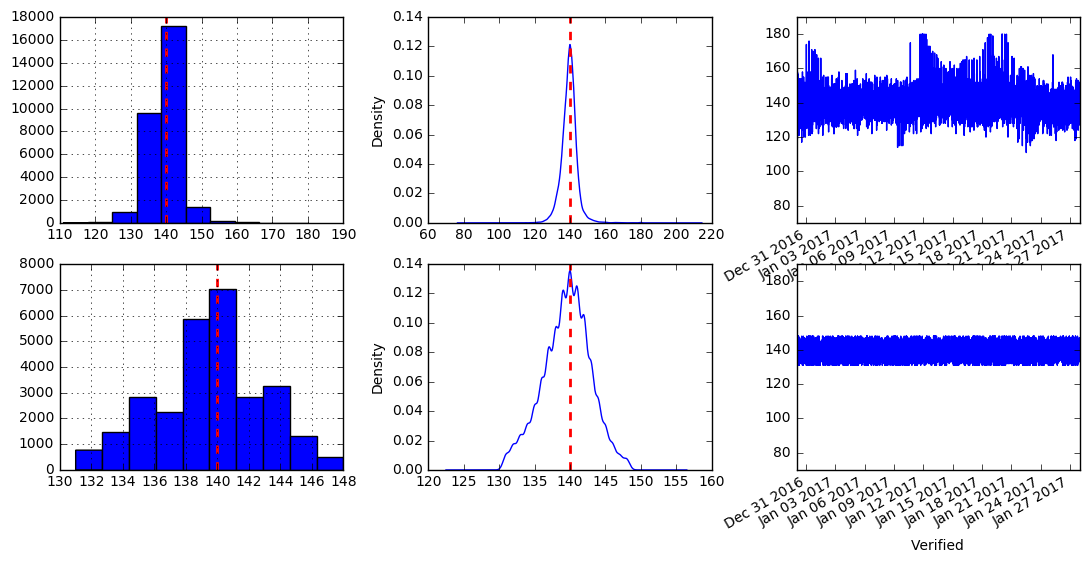

In [78]:
UTL = 148.54
LTL = 130.64

parse_dates = ['Verified']
df = pd.read_csv(SODIUM_CSV_PATH, parse_dates=parse_dates)

df = df.sort_values(by='Verified')
df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1')]
df_ = df_[['Verified','Value']]
df_.to_csv('tmp.csv', index=False)

val_series = pd.Series.from_csv('tmp.csv',header=0)
norm_val_series = val_series[(val_series <= UTL) & (val_series >= LTL)]

print "\nSize of Sodium series: {}\n".format(len(val_series))
print "{} - {}\n".format(val_series.index[0],val_series.index[-1])
print ("Sodium Descriptors:\n{}\n".format(val_series.describe()))

print ("Sodium Median:{}\n".format(val_series.median()))
print ("Sodium CV:{}\n".format((val_series.mean() - val_series.median())/val_series.std()))

print ("Sodium Skew: {}\n".format(val_series.skew()))
print ("Sodium Kurtosis: {}\n".format(val_series.kurtosis()))

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(left=0.05, wspace=0.3)

ax1 = fig.add_subplot(331)
ax1 = val_series.hist()
ax1.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax2 = fig.add_subplot(332)
ax2 = val_series.plot(kind='kde')
ax2.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax3 = fig.add_subplot(333)
ax3 = val_series.plot(ylim=(70,190))

ax4 = fig.add_subplot(334)
ax4 = norm_val_series.hist()
ax4.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax5 = fig.add_subplot(335)
ax5 = norm_val_series.plot(kind='kde')
ax5.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax6 = fig.add_subplot(336)
ax6 = norm_val_series.plot(ylim=(70,190))

print "\nSize of Normal Sodium series: {}\n".format(len(norm_val_series))
print "{} - {}\n".format(norm_val_series.index[0],norm_val_series.index[-1])
print ("Normal Sodium Descriptors:\n{}\n".format(norm_val_series.describe()))

print ("Normal Sodium Median:{}\n".format(norm_val_series.median()))
print ("Normal Sodium CV:{}\n".format((norm_val_series.mean() - norm_val_series.median())/norm_val_series.std()))

print ("Normal Sodium Skew: {}\n".format(norm_val_series.skew()))
print ("Normal Sodium Kurtosis: {}\n".format(norm_val_series.kurtosis()))

# Potassium


Size of Potassium series: 29174

2016-12-30 00:34:00 - 2017-01-28 00:36:00

Potassium Descriptors:
count    28564.000000
mean         4.199993
std          0.578461
min          1.900000
25%          3.800000
50%          4.200000
75%          4.500000
max          8.900000
Name: Value, dtype: float64

Potassium Median:4.2

Potassium CV:-1.2104215256e-05

Potassium Skew: 0.680757033975

Potassium Kurtosis: 2.40588625314


Size of Normal Potassium series: 27099

2016-12-30 00:34:00 - 2017-01-28 00:26:00

Normal Potassium Descriptors:
count    27099.000000
mean         4.165633
std          0.465209
min          3.100000
25%          3.800000
50%          4.200000
75%          4.500000
max          5.300000
Name: Value, dtype: float64

Normal Potassium Median:4.2

Normal Potassium CV:-0.0738734800505

Normal Potassium Skew: 0.116127882231

Normal Potassium Kurtosis: -0.311566990553



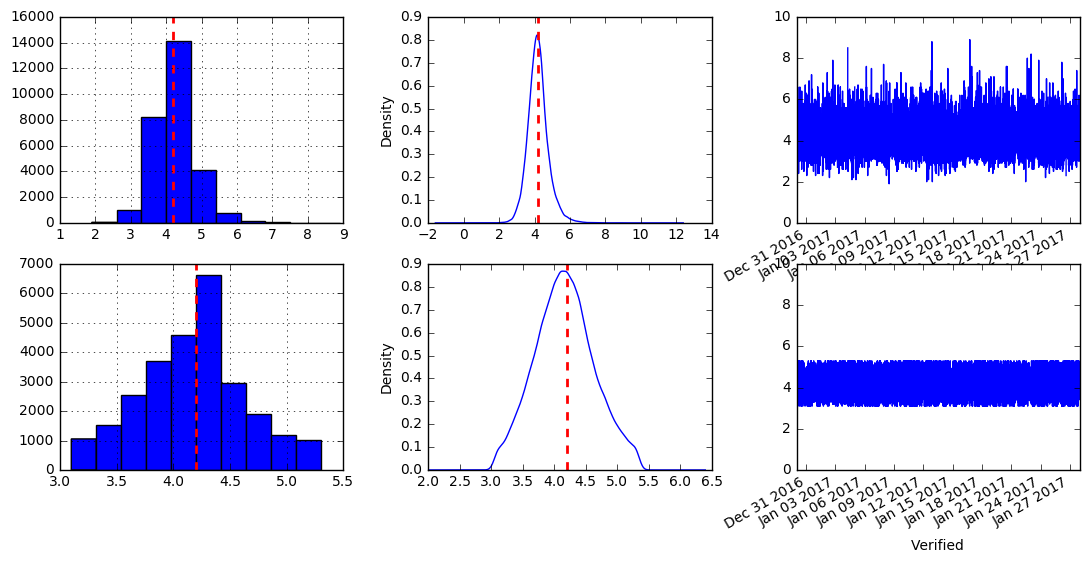

In [82]:
UTL = 5.356915
LTL = 3.043071

parse_dates = ['Verified']
df = pd.read_csv(POTASSIUM_CSV_PATH, parse_dates=parse_dates)

df = df.sort_values(by='Verified')
df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1')]
df_ = df_[['Verified','Value']]
df_.to_csv('tmp.csv', index=False)

val_series = pd.Series.from_csv('tmp.csv',header=0)
norm_val_series = val_series[(val_series <= UTL) & (val_series >= LTL)]

print "\nSize of Potassium series: {}\n".format(len(val_series))
print "{} - {}\n".format(val_series.index[0],val_series.index[-1])
print ("Potassium Descriptors:\n{}\n".format(val_series.describe()))

print ("Potassium Median:{}\n".format(val_series.median()))
print ("Potassium CV:{}\n".format((val_series.mean() - val_series.median())/val_series.std()))

print "Potassium Skew: {}\n".format(val_series.skew())
print "Potassium Kurtosis: {}\n".format(val_series.kurtosis())


fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(left=0.05, wspace=0.3)

ax1 = fig.add_subplot(331)
ax1 = val_series.hist()
ax1.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax2 = fig.add_subplot(332)
ax2 = val_series.plot(kind='kde')
ax2.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax3 = fig.add_subplot(333)
ax3 = val_series.plot(ylim=(0,10))

ax4 = fig.add_subplot(334)
ax4 = norm_val_series.hist()
ax4.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax5 = fig.add_subplot(335)
ax5 = norm_val_series.plot(kind='kde')
ax5.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax6 = fig.add_subplot(336)
ax6 = norm_val_series.plot(ylim=(0,10))


print "\nSize of Normal Potassium series: {}\n".format(len(norm_val_series))
print "{} - {}\n".format(norm_val_series.index[0],norm_val_series.index[-1])
print ("Normal Potassium Descriptors:\n{}\n".format(norm_val_series.describe()))

print ("Normal Potassium Median:{}\n".format(norm_val_series.median()))
print ("Normal Potassium CV:{}\n".format((norm_val_series.mean() - norm_val_series.median())/norm_val_series.std()))

print ("Normal Potassium Skew: {}\n".format(norm_val_series.skew()))
print ("Normal Potassium Kurtosis: {}\n".format(norm_val_series.kurtosis()))


# Chloride


Size of chloride series: 22878

2016-12-30 00:34:00 - 2017-01-29 16:02:00

Chloride Descriptors:
count    22873.00000
mean       101.04901
std          5.43728
min         53.00000
25%         98.00000
50%        101.00000
75%        104.00000
max        140.00000
Name: Value, dtype: float64

Chloride Median:101.0

Chloride CV:0.00901365237554

Chloride Skew: 0.15266669075

Chloride Kurtosis: 4.64782041691


Size of Normal Chloride series: 21586

2016-12-30 00:34:00 - 2017-01-29 16:02:00

Normal Chloride Descriptors:
count    21586.000000
mean       101.073381
std          4.095534
min         91.000000
25%         98.000000
50%        101.000000
75%        104.000000
max        111.000000
Name: Value, dtype: float64

Normal Chloride Median:101.0

Normal Chloride CV:0.0179172971859

Normal Chloride Skew: -0.122800424923

Normal Chloride Kurtosis: -0.22164111447



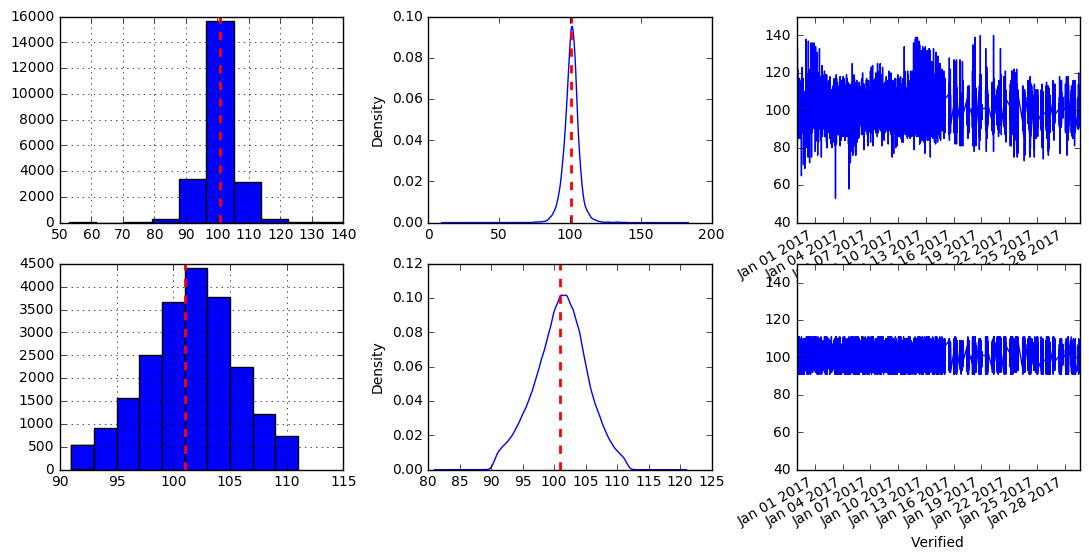

In [83]:
UTL = 111.92357
LTL = 90.17445

arse_dates = ['Verified']
df = pd.read_csv(CLORIDE_CSV_PATH, parse_dates=parse_dates)

df = df.sort_values(by='Verified')
df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1')]
df_ = df_[['Verified','Value']]
df_.to_csv('tmp.csv', index=False)

val_series = pd.Series.from_csv('tmp.csv',header=0)
norm_val_series = val_series[(val_series <= UTL) & (val_series >= LTL)]

print "\nSize of chloride series: {}\n".format(len(val_series))
print "{} - {}\n".format(val_series.index[0],val_series.index[-1])
print ("Chloride Descriptors:\n{}\n".format(val_series.describe()))

print ("Chloride Median:{}\n".format(val_series.median()))
print ("Chloride CV:{}\n".format((val_series.mean() - val_series.median())/val_series.std()))

print "Chloride Skew: {}\n".format(val_series.skew())
print "Chloride Kurtosis: {}\n".format(val_series.kurtosis())

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(left=0.05, wspace=0.3)

ax1 = fig.add_subplot(331)
ax1 = val_series.hist()
ax1.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax2 = fig.add_subplot(332)
ax2 = val_series.plot(kind='kde')
ax2.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax3 = fig.add_subplot(333)
ax3 = val_series.plot(ylim=(40,150))

ax4 = fig.add_subplot(334)
ax4 = norm_val_series.hist()
ax4.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax5 = fig.add_subplot(335)
ax5 = norm_val_series.plot(kind='kde')
ax5.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax6 = fig.add_subplot(336)
ax6 = norm_val_series.plot(ylim=(40,150))


print "\nSize of Normal Chloride series: {}\n".format(len(norm_val_series))
print "{} - {}\n".format(norm_val_series.index[0],norm_val_series.index[-1])
print ("Normal Chloride Descriptors:\n{}\n".format(norm_val_series.describe()))

print ("Normal Chloride Median:{}\n".format(norm_val_series.median()))
print ("Normal Chloride CV:{}\n".format((norm_val_series.mean() - norm_val_series.median())/norm_val_series.std()))

print ("Normal Chloride Skew: {}\n".format(norm_val_series.skew()))
print ("Normal Chloride Kurtosis: {}\n".format(norm_val_series.kurtosis()))

# Bicarb


Size of Bicarb series: 3386

2016-12-30 01:32:00 - 2017-01-27 23:26:00

Bicarb Descriptors:
count    3292.000000
mean       23.371203
std         4.401334
min         7.000000
25%        21.000000
50%        23.000000
75%        26.000000
max        50.000000
Name: Value, dtype: float64

Bicarb Median:23.0

Bicarb CV:0.08433873546

Bicarb Skew: 0.642226458427

Bicarb Kurtosis: 2.93306886452


Size of Normal Bicarb series: 3125

2016-12-30 01:34:00 - 2017-01-27 23:26:00

Normal Bicarb Descriptors:
count    3125.000000
mean       23.179840
std         3.425489
min        15.000000
25%        21.000000
50%        23.000000
75%        25.000000
max        32.000000
Name: Value, dtype: float64

Normal Bicarb Median:23.0

Normal Bicarb CV:0.052500538967

Normal Bicarb Skew: -0.000934939672326

Normal Bicarb Kurtosis: -0.0792308415707



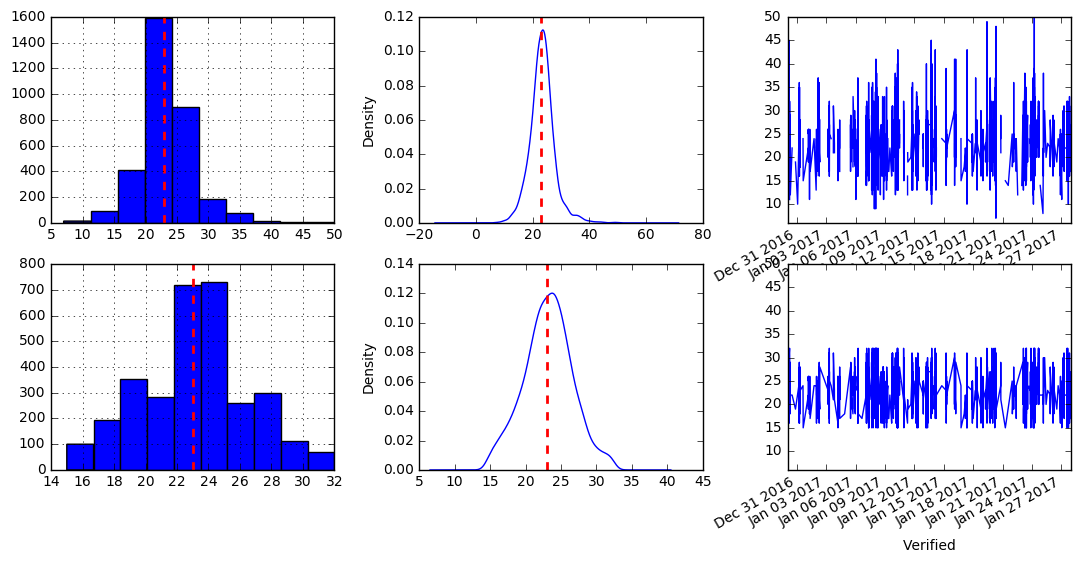

In [85]:
UTL = 32.173871
LTL = 14.568535

parse_dates = ['Verified']
df = pd.read_csv(C02_CSV_PATH, parse_dates=parse_dates)

df = df.sort_values(by='Verified')
df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1')]
df_ = df_[['Verified','Value']]
df_.to_csv('tmp.csv', index=False)

val_series = pd.Series.from_csv('tmp.csv',header=0)
norm_val_series = val_series[(val_series <= UTL) & (val_series >= LTL)]

print "\nSize of Bicarb series: {}\n".format(len(val_series))
print "{} - {}\n".format(val_series.index[0],val_series.index[-1])
print ("Bicarb Descriptors:\n{}\n".format(val_series.describe()))

print ("Bicarb Median:{}\n".format(val_series.median()))
print ("Bicarb CV:{}\n".format((val_series.mean() - val_series.median())/val_series.std()))

print "Bicarb Skew: {}\n".format(val_series.skew())
print "Bicarb Kurtosis: {}\n".format(val_series.kurtosis())

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(left=0.05, wspace=0.3)

ax1 = fig.add_subplot(331)
ax1 = val_series.hist()
ax1.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax2 = fig.add_subplot(332)
ax2 = val_series.plot(kind='kde')
ax2.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax3 = fig.add_subplot(333)
ax3 = val_series.plot(ylim=(6,50))

ax4 = fig.add_subplot(334)
ax4 = norm_val_series.hist()
ax4.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax5 = fig.add_subplot(335)
ax5 = norm_val_series.plot(kind='kde')
ax5.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax6 = fig.add_subplot(336)
ax6 = norm_val_series.plot(ylim=(6,50))


print "\nSize of Normal Bicarb series: {}\n".format(len(norm_val_series))
print "{} - {}\n".format(norm_val_series.index[0],norm_val_series.index[-1])
print ("Normal Bicarb Descriptors:\n{}\n".format(norm_val_series.describe()))

print ("Normal Bicarb Median:{}\n".format(norm_val_series.median()))
print ("Normal Bicarb CV:{}\n".format((norm_val_series.mean() - norm_val_series.median())/norm_val_series.std()))

print ("Normal Bicarb Skew: {}\n".format(norm_val_series.skew()))
print ("Normal Bicarb Kurtosis: {}\n".format(norm_val_series.kurtosis()))

# BUN


Size of BUN series: 5378

2016-12-30 01:32:00 - 2017-01-27 23:26:00

BUN Descriptors:
count    5373.000000
mean       23.950121
std        20.563473
min         2.000000
25%        12.000000
50%        18.000000
75%        29.000000
max       221.000000
Name: Value, dtype: float64

BUN Median:18.0

BUN CV:0.289353897621

BUN Skew: 2.82257370817

BUN Kurtosis: 12.3791132256


Size of Normal BUN series: 5108

2016-12-30 01:32:00 - 2017-01-27 23:26:00

Normal BUN Descriptors:
count    5108.000000
mean       20.475333
std        12.802363
min         2.000000
25%        11.000000
50%        17.000000
75%        26.000000
max        65.000000
Name: Value, dtype: float64

Normal BUN Median:17.0

Normal BUN CV:0.271460254201

Normal BUN Skew: 1.26308989417

Normal BUN Kurtosis: 1.2984801217



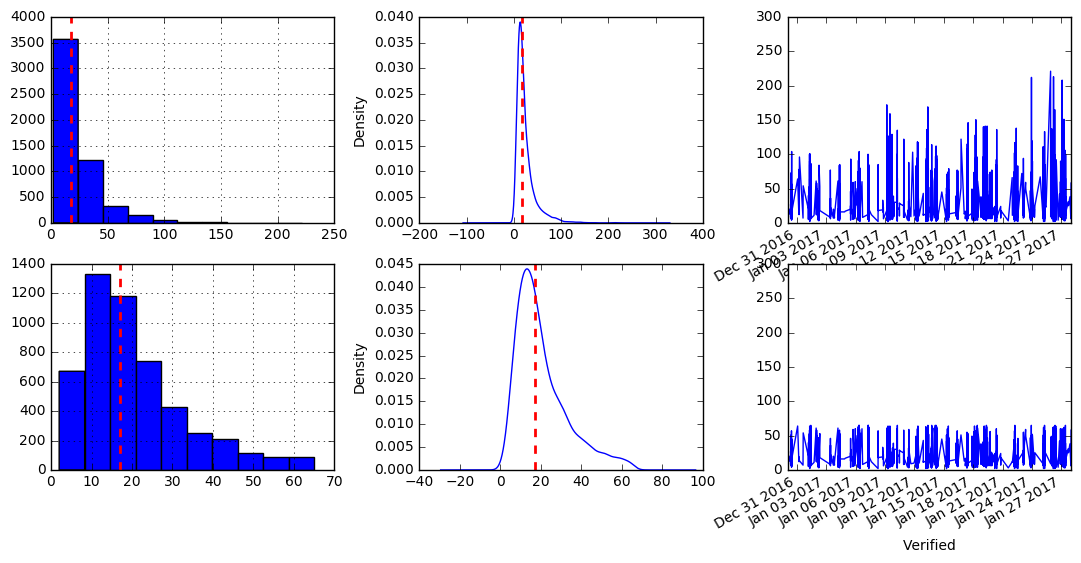

In [90]:
UTL = 65.077067
LTL = 0

parse_dates = ['Verified']
df = pd.read_csv(BUN_CSV_PATH, parse_dates=parse_dates)

df = df.sort_values(by='Verified')
df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1')]
df_ = df_[['Verified','Value']]
df_.to_csv('tmp.csv', index=False)

val_series = pd.Series.from_csv('tmp.csv',header=0)
norm_val_series = val_series[(val_series <= UTL) & (val_series >= LTL)]

print "\nSize of BUN series: {}\n".format(len(val_series))
print "{} - {}\n".format(val_series.index[0],val_series.index[-1])
print ("BUN Descriptors:\n{}\n".format(val_series.describe()))

print ("BUN Median:{}\n".format(val_series.median()))
print ("BUN CV:{}\n".format((val_series.mean() - val_series.median())/val_series.std()))

print "BUN Skew: {}\n".format(val_series.skew())
print "BUN Kurtosis: {}\n".format(val_series.kurtosis())

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(left=0.05, wspace=0.3)

ax1 = fig.add_subplot(331)
ax1 = val_series.hist()
ax1.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax2 = fig.add_subplot(332)
ax2 = val_series.plot(kind='kde')
ax2.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax3 = fig.add_subplot(333)
ax3 = val_series.plot(ylim=(0,300))

ax4 = fig.add_subplot(334)
ax4 = norm_val_series.hist()
ax4.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax5 = fig.add_subplot(335)
ax5 = norm_val_series.plot(kind='kde')
ax5.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax6 = fig.add_subplot(336)
ax6 = norm_val_series.plot(ylim=(0,300))


print "\nSize of Normal BUN series: {}\n".format(len(norm_val_series))
print "{} - {}\n".format(norm_val_series.index[0],norm_val_series.index[-1])
print ("Normal BUN Descriptors:\n{}\n".format(norm_val_series.describe()))

print ("Normal BUN Median:{}\n".format(norm_val_series.median()))
print ("Normal BUN CV:{}\n".format((norm_val_series.mean() - norm_val_series.median())/norm_val_series.std()))

print ("Normal BUN Skew: {}\n".format(norm_val_series.skew()))
print ("Normal BUN Kurtosis: {}\n".format(norm_val_series.kurtosis()))

# Creatinine


Size of Creatinine series: 1232

2016-12-30 01:32:00 - 2017-01-27 23:26:00

Creatinine Descriptors:
count    1229.000000
mean        1.206778
std         1.400861
min         0.130000
25%         0.600000
50%         0.810000
75%         1.150000
max        19.910000
Name: Value, dtype: float64

Creatinine Median:0.81

Creatinine CV:0.283238508528

Creatinine Skew: 5.01875843589

Creatinine Kurtosis: 39.7803800567


Size of Normal Creatinine series: 1178

2016-12-30 01:32:00 - 2017-01-27 22:58:00

Normal Creatinine Descriptors:
count    1178.000000
mean        0.977309
std         0.671916
min         0.130000
25%         0.590000
50%         0.800000
75%         1.110000
max         3.980000
Name: Value, dtype: float64

Normal Creatinine Median:0.8

Normal Creatinine CV:0.263885494941

Normal Creatinine Skew: 2.20152392962

Normal Creatinine Kurtosis: 5.41488320132



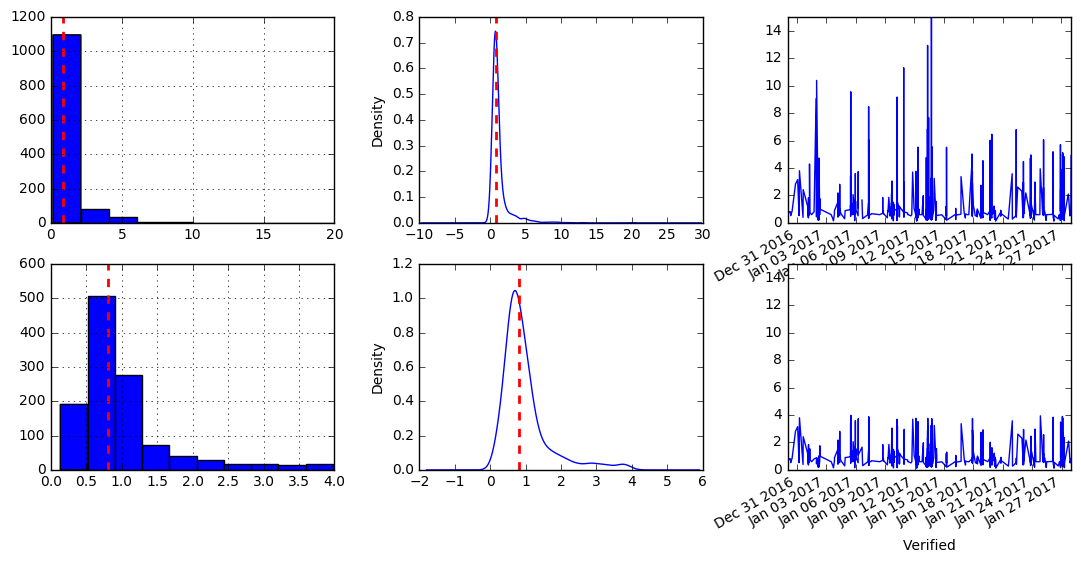

In [91]:
UTL = 4
LTL = 0

parse_dates = ['Verified']
df = pd.read_csv(CR_CSV_PATH, parse_dates=parse_dates)

df = df.sort_values(by='Verified')
df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1')]
df_ = df_[['Verified','Value']]
df_.to_csv('tmp.csv', index=False)

val_series = pd.Series.from_csv('tmp.csv',header=0)
norm_val_series = val_series[(val_series <= UTL) & (val_series >= LTL)]

print "\nSize of Creatinine series: {}\n".format(len(val_series))
print "{} - {}\n".format(val_series.index[0],val_series.index[-1])
print ("Creatinine Descriptors:\n{}\n".format(val_series.describe()))

print ("Creatinine Median:{}\n".format(val_series.median()))
print ("Creatinine CV:{}\n".format((val_series.mean() - val_series.median())/val_series.std()))

print "Creatinine Skew: {}\n".format(val_series.skew())
print "Creatinine Kurtosis: {}\n".format(val_series.kurtosis())

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(left=0.05, wspace=0.3)

ax1 = fig.add_subplot(331)
ax1 = val_series.hist()
ax1.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax2 = fig.add_subplot(332)
ax2 = val_series.plot(kind='kde')
ax2.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax3 = fig.add_subplot(333)
ax3 = val_series.plot(ylim=(0,15))

ax4 = fig.add_subplot(334)
ax4 = norm_val_series.hist()
ax4.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax5 = fig.add_subplot(335)
ax5 = norm_val_series.plot(kind='kde')
ax5.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax6 = fig.add_subplot(336)
ax6 = norm_val_series.plot(ylim=(0,15))


print "\nSize of Normal Creatinine series: {}\n".format(len(norm_val_series))
print "{} - {}\n".format(norm_val_series.index[0],norm_val_series.index[-1])
print ("Normal Creatinine Descriptors:\n{}\n".format(norm_val_series.describe()))

print ("Normal Creatinine Median:{}\n".format(norm_val_series.median()))
print ("Normal Creatinine CV:{}\n".format((norm_val_series.mean() - norm_val_series.median())/norm_val_series.std()))

print ("Normal Creatinine Skew: {}\n".format(norm_val_series.skew()))
print ("Normal Creatinine Kurtosis: {}\n".format(norm_val_series.kurtosis()))

# Glucose


Size of Glucose series: 2284

2016-12-30 01:32:00 - 2017-01-27 23:26:00

Glucose Descriptors:
count    2280.000000
mean      117.380263
std        74.735577
min        31.000000
25%        80.000000
50%        99.000000
75%       126.000000
max      1317.000000
Name: Value, dtype: float64

Glucose Median:99.0

Glucose CV:0.245937261997

Glucose Skew: 6.82846800645

Glucose Kurtosis: 69.3533218467


Size of Normal Glucose series: 2228

2016-12-30 01:32:00 - 2017-01-27 23:26:00

Normal Glucose Descriptors:
count    2228.000000
mean      108.995063
std        36.986089
min        31.000000
25%        80.000000
50%        98.000000
75%       124.000000
max       266.000000
Name: Value, dtype: float64

Normal Glucose Median:98.0

Normal Glucose CV:0.297275627089

Normal Glucose Skew: 1.58910509719

Normal Glucose Kurtosis: 2.56187553217



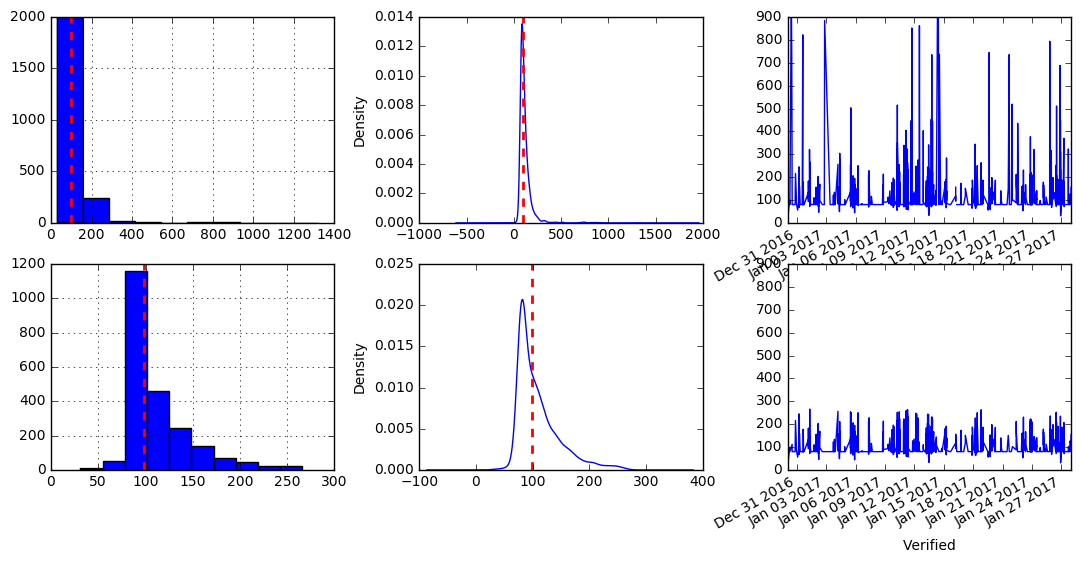

In [92]:
UTL = 266
LTL = 0

parse_dates = ['Verified']
df = pd.read_csv(GLUCOSE_CSV_PATH, parse_dates=parse_dates)

df = df.sort_values(by='Verified')
df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1')]
df_ = df_[['Verified','Value']]
df_.to_csv('tmp.csv', index=False)

val_series = pd.Series.from_csv('tmp.csv',header=0)
norm_val_series = val_series[(val_series <= UTL) & (val_series >= LTL)]

print "\nSize of Glucose series: {}\n".format(len(val_series))
print "{} - {}\n".format(val_series.index[0],val_series.index[-1])
print ("Glucose Descriptors:\n{}\n".format(val_series.describe()))


print ("Glucose Median:{}\n".format(val_series.median()))
print ("Glucose CV:{}\n".format((val_series.mean() - val_series.median())/val_series.std()))

print "Glucose Skew: {}\n".format(val_series.skew())
print "Glucose Kurtosis: {}\n".format(val_series.kurtosis())

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(left=0.05, wspace=0.3)

ax1 = fig.add_subplot(331)
ax1 = val_series.hist()
ax1.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax2 = fig.add_subplot(332)
ax2 = val_series.plot(kind='kde')
ax2.axvline(val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax3 = fig.add_subplot(333)
ax3 = val_series.plot(ylim=(0,900))

ax4 = fig.add_subplot(334)
ax4 = norm_val_series.hist()
ax4.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)

ax5 = fig.add_subplot(335)
ax5 = norm_val_series.plot(kind='kde')
ax5.axvline(norm_val_series.median(), color='r', linestyle='dashed', linewidth=2)
 
ax6 = fig.add_subplot(336)
ax6 = norm_val_series.plot(ylim=(0,900))


print "\nSize of Normal Glucose series: {}\n".format(len(norm_val_series))
print "{} - {}\n".format(norm_val_series.index[0],norm_val_series.index[-1])
print ("Normal Glucose Descriptors:\n{}\n".format(norm_val_series.describe()))

print ("Normal Glucose Median:{}\n".format(norm_val_series.median()))
print ("Normal Glucose CV:{}\n".format((norm_val_series.mean() - norm_val_series.median())/norm_val_series.std()))

print ("Normal Glucose Skew: {}\n".format(norm_val_series.skew()))
print ("Normal Glucose Kurtosis: {}\n".format(norm_val_series.kurtosis()))